<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/catagotical%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [12]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import tracemalloc

import tensorflow_probability as tfp

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Concatenate, GaussianNoise
from tensorflow.keras.regularizers import l2


### <font color='purple'><center>**-------------------Create Data-------------------**</font>

In [14]:
end_date = datetime.now() - timedelta(days=1)
start_date = end_date - timedelta(days=728)

tickers = [
    'EURUSD=X', 'USDEUR=X',  # Euro/US Dollar
    'USDJPY=X', 'JPYUSD=X',  # US Dollar/Japanese Yen
    'GBPUSD=X', 'USDGBP=X',  # British Pound/US Dollar
    'USDCHF=X', 'CHFUSD=X',  # US Dollar/Swiss Franc
    'AUDUSD=X', 'USDAUD=X',  # Australian Dollar/US Dollar
    'USDCAD=X', 'CADUSD=X',  # US Dollar/Canadian Dollar
    'NZDUSD=X', 'USDNZD=X',  # New Zealand Dollar/US Dollar
]

data_list = []
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval='1h')
    data_list.append(data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [15]:
def create_data(raw_data, window_size):
    High = raw_data['High'].to_numpy()
    Close = raw_data['Close'].to_numpy()
    Low = raw_data['Low'].to_numpy()
    Std = np.std(np.diff(Close))
    Close_Diff = np.diff(Close)/Std
    High_Adj = (High[1:]-Close[1:])/Std
    Low_Adj = (Close[1:]-Low[1:])/Std

    stack = np.stack((Close_Diff, High_Adj, Low_Adj), axis=1)

    window_view = np.lib.stride_tricks.sliding_window_view(stack, (window_size,),axis=0)

    Forex_Data = window_view[:-1]
    Forex_Data = Forex_Data.astype('float32')
    target = Close_Diff[window_size:]

    return Forex_Data, target


In [16]:
window_list = []
target_list = []
for data in data_list:
    window, target =  create_data(data, 50)
    window_list.append(window)
    target_list.append(target)


In [40]:
# Assume data is your numpy array and bins is a numpy array defining your bins
data = target_list[0]
input_data = window_list[0]
for i in range(len(target_list)-1):

  data = np.append(data,target_list[i+1])
  input_data = np.append(input_data, window_list[i+1],axis=0)



bin_num = 51
space = 1
bins = np.linspace(-space, space, bin_num-1)
digitized = np.digitize(data, bins, right=False)
digitized = tf.keras.utils.to_categorical(digitized)
shape = digitized.shape[1]

In [41]:
print(data)
print(input_data.shape)
print(shape)

[-0.10750975  0.10750975  0.10741436 ... -0.07914583  0.15829166
 -0.59349938]
(172236, 3, 50)
51


In [42]:
from keras.optimizers import Adam

Drop_val=.5
# Initialize the model
model = Sequential()

# Add the LSTM layer
model.add(LSTM(128,dropout=Drop_val,recurrent_dropout=Drop_val))

model.add(BatchNormalization())

model.add(Dense(100,activation='gelu'))

model.add(BatchNormalization())

model.add(Dropout(Drop_val))

model.add(Dense(50,activation='gelu'))

model.add(BatchNormalization())

model.add(Dropout(Drop_val))


# Add the Dense layer
model.add(Dense(shape, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
model.fit(input_data, digitized, epochs=200, batch_size=32,validation_split=.2)

Epoch 1/200
4306/4306 [==============================] - 70s 15ms/step - loss: 3.7353 - accuracy: 0.0951 - val_loss: 3.6421 - val_accuracy: 0.1051
Epoch 2/200
4306/4306 [==============================] - 63s 15ms/step - loss: 3.6129 - accuracy: 0.1070 - val_loss: 3.6439 - val_accuracy: 0.1051
Epoch 3/200
4306/4306 [==============================] - 64s 15ms/step - loss: 3.6041 - accuracy: 0.1082 - val_loss: 3.6431 - val_accuracy: 0.1070
Epoch 4/200
4306/4306 [==============================] - 64s 15ms/step - loss: 3.5997 - accuracy: 0.1065 - val_loss: 3.6366 - val_accuracy: 0.1084
Epoch 5/200
4306/4306 [==============================] - 60s 14ms/step - loss: 3.5963 - accuracy: 0.1078 - val_loss: 3.6570 - val_accuracy: 0.1029
Epoch 6/200
4306/4306 [==============================] - 61s 14ms/step - loss: 3.5949 - accuracy: 0.1077 - val_loss: 3.6527 - val_accuracy: 0.1013
Epoch 7/200
4306/4306 [==============================] - 63s 15ms/step - loss: 3.5928 - accuracy: 0.1078 - val_loss: 3

KeyboardInterrupt: ignored

In [43]:
pred = model.predict(input_data)
num = 0

5383/5383 [==============================] - 18s 3ms/step



0.012971226361114547
51
-0.6473479806553026


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

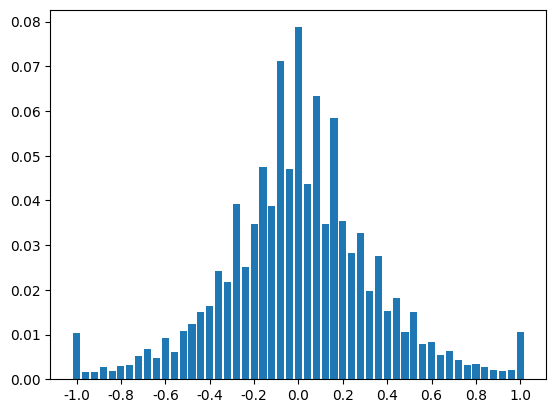

In [65]:
num += 1
dist = pred[num]
print()
val = target_list[0][num]

values = np.linspace(-space, space, shape)

#round the numbers to one decimal place and only include every other value
values2 = [round(value, 2) for value in values[::5]]




bin_centers = (values[:-1] + values[1:]) / 2
dist2 = dist[:len(bin_centers)]


# Calculate the mean of the distribution
mean = np.sum(dist2 * bin_centers)


print(mean)
print(shape)
print(val)
plt.bar(range(shape), dist)
# Create a line plot on the bar chart

plt.xticks(range(len(dist))[::5], values2)

plt.plot